In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
print(np.__version__)
print(np.__path__)
import pandas as pd
from scipy.stats import norm, truncnorm
from manada.Sources.sersic import SingleSersicSource
from manada.MainDeflector.simple_deflectors import PEMD
from manada.Sources.cosmos import COSMOSCatalog
from manada.Sources.cosmos_sersic import COSMOSSersic
from manada.PointSource.single_point_source import SinglePointSource
import manada
from manada.Sampling.sampler import Sampler
from manada.Sources.source_base import SourceBase
from lenstronomy.SimulationAPI.data_api import DataAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import matplotlib.pyplot as plt
import os, subprocess, sys
from matplotlib import colors
from astropy.visualization import simple_norm
from fastell4py import _fastell
from manada.generate import draw_image

root_path = manada.__path__[0][:-7]

print(root_path)

1.19.5
['/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/numpy']
/Users/smericks/Desktop/StrongLensing/manada


# Changes to Manada, Fall Quarter 2021

__Author:__ Sydney Erickson with help from Sebastian Wagner-Carena and Ji Won Park

__Goals:__ 

- Show how Manada operated before Fall 2021 changes<br>
- Walk through each change and demonstrate its impact<br>
1. [COSMOS + Sersic Source](#cosmos_sersic)
2. [Point Source](#point_source)
3. [Point Source Magnification Errors](#mag_pert)
4. [Lens Light](#lens_light)
5. [Time Delay Metadata](#time_delay)


## Before Changes

__Generate a training set using COSMOS galaxies__

Prior to my contributions, Sebastian provided capability to use COSMOS galaxies as source light instead of a Sersic Ellipse. The COSMOS galaxy library is found here: https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy%20Data. Be sure to download and unzip the 23.5 training sample before running this notebook. 


In [ ]:
#Generate COSMOS Training Set

# Change our working directory to the location of generate.py
os.chdir(os.path.join(root_path,'manada'))
config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_COSMOSonly.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/COSMOS_data')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Plot images of the new training set:

In [ ]:
#Plot images
# Load the metadata
# Sebastian - this is where I see an error in the metadata.csv
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)

nt=0
image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
norm=simple_norm(image, stretch='asinh', min_cut=1e-4)

#make a matrix and plot it once
matrix = np.ones((3*128, 3*128))
for i in range(0,3) :
    left_i = i*128
    right_i = i*128 +128
    for j in range(0,3) :
        left_j = j*128
        right_j = j*128 + 128
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        matrix[left_i:right_i,left_j:right_j]= image
        nt+=1

plt.figure(figsize=(8,8))
plt.matshow(matrix,origin='lower',norm=norm,cmap='plasma',fignum=1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('COSMOS Host Galaxy Training Set')
plt.show()

__Generate a training set using a single sersic source__

Note that this is already done in the last section of Understanding_Manada_Pipeline notebook using the SingleSersicSource class. We will repeat the code here so that users can easily compare training sets generated using COSMOSCatalog and SingleSersicSource source classes.

In [ ]:
config_path = os.path.join(root_path,'notebooks/notebook_data/config_example.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/Sersic_data')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Plot images of the new training set:

In [ ]:
#Plot images
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'))

nt=8
#norm=simple_norm(np.load(os.path.join(output_path,'image_%07d.npy'%nt)), stretch='log', min_cut=1e-2)
norm=None
f, ax = plt.subplots(3,3,figsize=(6,6),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
nt = 0

for i in range(0,3) :
    for j in range(0,3) :
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].matshow(image, origin='lower', norm=norm, cmap='plasma')
        nt += 1

plt.suptitle('Sersic Only Training Set')
plt.show()

## After Changes

__1. Adding a Sersic light source on top of a COSMOS galaxy__<a class="anchor" id="cosmos_sersic"></a>

The first step was to make a source class, COSMOSSersic, that is used to generate images with two sources added together: a Sersic Ellipse and a COSMOS galaxy. This isn't intended to represent anything physical, rather it will be used to validate image positions when adding a point source to a COSMOS galaxy.

Generate a training set using the COSMOSSersic source class.

In [ ]:
# Let's generate a training set using this new source class

config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_COSMOSSersic.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/COSMOSSersicData')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Plot images of the new training set:

In [ ]:
#Plot images
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'))

plt.rcParams["figure.figsize"] = (12,12)
#norm=None
nt=8
norm=simple_norm(np.load(os.path.join(output_path,'image_%07d.npy'%nt)), stretch='asinh', min_cut=1e-4)
#norm=None
f, ax = plt.subplots(3,3,figsize=(6,6),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
nt = 0
for i in range(0,3) :
    for j in range(0,3) :
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].matshow(image, origin='lower', norm=norm, cmap='plasma')
        nt += 1
plt.suptitle('COSMOS + Sersic Training Set')
plt.show()

In addition to generating a training set using this new source class, we want to investigate the output in more detail. We'll define a configuration dictionary that will be used with the draw_image() function located in the generate.py file to generate and investigate single images. 

Define configuration dictionaries for single image generation:

In [ ]:
numpix = 128
kwargs_numerics = {'supersampling_factor':2}
cosmos_folder = '/Users/smericks/Desktop/StrongLensing/COSMOS_23.5_training_sample/'

config_dict = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.3,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': COSMOSSersic,
        'parameters':{
	        'z_source':1.5,
	        'cosmos_folder':cosmos_folder,
	        'max_z':0.05,
            'minimum_size_in_pixels':650,'min_apparent_mag':20,
            'smoothing_sigma':0.08,'random_rotation':False,
	        'min_flux_radius':10.0,
	        'output_ab_zeropoint':25.127,
	        # start w/ mag=20, see if bright enough to see Sersic
	        'mag_sersic':22,
	        'R_sersic':0.1,
            'n_sersic':2.5,
	        'e1_sersic':0,
	        'e2_sersic':0,
	        'center_x_sersic':0.0,
	        'center_y_sersic':0.0}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
		'parameters':{
			'psf_type':'GAUSSIAN',
			'fwhm': 0.1
		}
	},
    'detector':{
        'parameters':{'pixel_scale':0.04,'magnitude_zero_point':25,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

# 2nd dict is only used to validate what subtraction should look like w/ SingleSersicSource

config_dict_sersic = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.3,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': SingleSersicSource,
        'parameters':{
	        'z_source':1.5,
	        'magnitude':22,
            'output_ab_zeropoint':25.127,
	        'R_sersic':0.1,
            'n_sersic':2.5,
	        'e1':0,
	        'e2':0,
	        'center_x':0.0,
	        'center_y':0.0}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
        'parameters':{'psf_type':'NONE'}
    },
    'detector':{
        'parameters':{'pixel_scale':0.04,'magnitude_zero_point':25,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

Let's do a simple sanity check. If we use our COSMOSSersic source class, make sure that the componenets are added together properly.

In [ ]:
from manada.generate import draw_image

sampler = Sampler(config_dict)
sample = sampler.sample()

main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])
#generates an image no PSF, no noise

# use source_class = COSMOSCatalog
# returns np.array of image & a dict of metadata
source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)

# use source_class = COSMOSSersic
# returns np.array of image & a dict of metadata
source_class = config_dict['source']['class'](
		sample['cosmology_parameters'],sample['source_parameters'])
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)


sampler_s = Sampler(config_dict_sersic)
sample_s = sampler_s.sample()

main_deflector_class = config_dict_sersic['main_deflector']['class'](
			sample_s['main_deflector_parameters'],sample_s['cosmology_parameters'])
source_class = config_dict_sersic['source']['class'](
		sample_s['cosmology_parameters'],sample_s['source_parameters'])
#generates an image no PSF, no noise

# use source_class = COSMOSSersic
# returns np.array of image & a dict of metadata
im_s, metadata_s = draw_image(sample=sample_s,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)


#plt.rcParams["figure.figsize"] = (12,6)
#norm=None
norm=simple_norm(im2, stretch='log', min_cut=1e-3)
# 3 images: COSMOS, COSMOS+Sersic, COSMOS+Sersic - COSMOS
im3 = im2 - im1

images = [im1, im2, im3, im_s]
titles = ['COSMOS Only', 'COSMOS + Sersic', 'Subtracted Sersic', 'Original Sersic']


f, ax = plt.subplots(1,4,figsize=(16,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,4) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower', norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=20)

plt.show()

__2. Adding a new class: PointSource__<a class="anchor" id="point_source"></a>

Point sources must be treated differently than other light sources, so we can't use the existing Source class type. We define a new type, PointSource, that is optional to include in the configuration dictionary. The point source must be used along with a light source (such as a COSMOS host galaxy). We created a new source class located in the PointSource folder called SinglePointSource. 

Note, this changes how we call draw_image() in generate.py, because we now expect a point_source_class to be passed. If not used, we set this to None.

Generate a training set using the SinglePointSource class with a COSMOS host galaxy:

In [ ]:
config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_PointSource.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/PointSourceData')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Plot images of the new training set:

In [ ]:
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)

nt=0
image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
#norm=simple_norm(image/np.max(image), stretch='asinh', min_cut=1e-4)

#make a matrix and plot it once
matrix = np.ones((3*128, 3*128))
for i in range(0,3) :
    left_i = i*128
    right_i = i*128 +128
    for j in range(0,3) :
        left_j = j*128
        right_j = j*128 + 128
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        matrix[left_i:right_i,left_j:right_j]= image
        nt+=1

plt.figure(figsize=(8,8))
plt.matshow(matrix,origin='lower',norm=norm,cmap='plasma',fignum=1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
m=0
for i in range(0,3):
    for j in range(0,3):
        num_images = metadata.at[m,'point_source_parameters_num_images']
        plt.text(j*128+20,i*128+115,'N Point Source Images: %0d'%num_images, color="snow", fontsize=10)
        m+=1
plt.title('COSMOS Host Galaxy + Point Source Training Set')
plt.show()

Again, we want to generate single images to perform some sanity checks. Modify the existing config_dict to include a point source:

In [ ]:
config_dict['point_source']  = {
        'class': SinglePointSource,
        'parameters':{
            'x_point_source':0.,
			'y_point_source':0.,
			'magnitude':18.75,
			'output_ab_zeropoint':25.127,
            'compute_time_delays':False}
    }

We want to verify the positions of the images from the point source using the COSMOSSersic source. Use a Sersic with high n_sersic and low R_sersic to generate a Sersic light distribution that is point source like. Verify that the images from the point source and the Sersic fall in the same place. 

In [ ]:
# change R_sersic, n_sersic, mag_sersic, point_source magnitude to generate image
config_dict['source']['parameters']['R_sersic'] = 0.001
config_dict['source']['parameters']['n_sersic'] = 6.5
config_dict['source']['parameters']['mag_sersic'] = 21

sampler = Sampler(config_dict)
sample = sampler.sample()

main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])

source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)
	
source_class = COSMOSSersic(sample['cosmology_parameters'],
							sample['source_parameters'])
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=None,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)


#plt.rcParams["figure.figsize"] = (12,6)

images = [im1, im2]
titles = ['COSMOS + Point Source', 'COSMOS + Sersic']
norm=simple_norm(images[0], stretch='log', min_cut=1e-3)

f, ax = plt.subplots(1,3,figsize=(16,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,3) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	if i < 2 :
		ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
		ax[i].set_title(titles[i], fontsize=20)
	else :
		norm=simple_norm(im2-im1, stretch='log', min_cut=1e-5)
		ax[i].matshow(im2-im1, origin='lower', norm=norm, cmap='plasma')
		ax[i].set_title('Difference (Right - Left)', fontsize=20)


plt.show()



Let's do another sanity check for the point source. If we have no lens mass, confirm that the total flux from the point source matches what we expect given the magnitude in the config_dict.

In [ ]:
from lenstronomy.Util.data_util import magnitude2cps

config_dict['point_source']['parameters']['magnitude'] = 5
config_dict['point_source']['parameters']['x_point_source'] = 0.001
config_dict['point_source']['parameters']['y_point_source'] = 0.001
# set mass = 0 so the lens effectively does nothing
config_dict['main_deflector']['parameters']['theta_E'] = 0

sampler = Sampler(config_dict)
sample = sampler.sample()

source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])

# COSMOS+PointSource
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=False)
# Just COSMOS
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)

# Just point source
plt.rcParams["figure.figsize"] = (5,5)
im_ps = im1-im2
plt.imshow(im_ps, cmap='plasma')
plt.show()


#im1 is a 2d array of surface brightness pixels
flux_true = magnitude2cps(config_dict['point_source']['parameters']['magnitude'], config_dict['point_source']['parameters']['output_ab_zeropoint'])
flux_image = np.sum(im_ps)

print("True Flux: ", flux_true)
print("Flux from image: ", flux_image)

__3. Point Source Magnification Pertubations__<a class="anchor" id="mag_pert"></a>

The next change implemented was to add capability to add magnification pertubations to images of a point source. This is an important effect to include, because all images are microlensed by objects along the light path, such as stars in the host galaxy. First, I added new capability to the Lenstronomy package to the SOURCE_POSITION Point Source type. This new capability allows the user to pass in a kwarg called 'mag_pert' (magnification pertubations), which is a list of fractional magnification errors that will be applied to each image. A demonstration of this added capability is included below.

Generating a new training set with this effect won't result in any changes noticeable to the human eye. Let's skip this step and use single images to demonstrate this capability.

Define a new configuration for generation of these images:

In [ ]:
# define new config_dict
numpix = 100
kwargs_numerics = {'supersampling_factor':2}
cosmos_folder = '/Users/smericks/Desktop/StrongLensing/COSMOS_23.5_training_sample/'

config_dict= {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.3,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': COSMOSCatalog,
        'parameters':{
	        'z_source':1.5,
	        'cosmos_folder':cosmos_folder,
	        'max_z':0.05,
            'minimum_size_in_pixels':650,'min_apparent_mag':20,
            'smoothing_sigma':0.08,'random_rotation':False,
	        'min_flux_radius':10.0,
	        'output_ab_zeropoint':25.127,}
    },
    'point_source':{
        'class': SinglePointSource,
        'parameters':{
            'x_point_source':0.,
			'y_point_source':0.,
			'magnitude':23,
			'output_ab_zeropoint':25.127,
            'compute_time_delays':False}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
		'parameters':{
			'psf_type':'GAUSSIAN',
			'fwhm': 0.08
		}
	},
    'detector':{
        'parameters':{'pixel_scale':0.04,'magnitude_zero_point':25.127,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

Show the same image before and after magnification pertubations are applied. Note that adding realistic pertubations won't result in any difference noticeable to the human eye, so a second case is included to make this change noticeable.

In [ ]:
# generate image w/ no magnification errors
from scipy.stats import norm

sampler = Sampler(config_dict)
sample = sampler.sample()

source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])

im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)

# generate image w/ magnification errors
mag_pert = norm(1,0.2).rvs(size=5)
config_dict['point_source']['parameters']['mag_pert'] = mag_pert
print('mag_pert: ', config_dict['point_source']['parameters']['mag_pert'])
sampler = Sampler(config_dict)
sample = sampler.sample()
point_source_class = SinglePointSource(sample['point_source_parameters'])

im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)

images = [im1, im2]
titles = ['Before', 'After']
norm=simple_norm(images[0], stretch='asinh', min_cut=1e-3)

f, ax = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,2) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=15)

plt.suptitle("Magnification Pertubations: [{:0.2f}, {:0.2f}, {:0.2f}, {:0.2f}]".format(mag_pert[0], mag_pert[1], mag_pert[2], mag_pert[3]), fontsize=15)
plt.show()

mag_pert = [1.5, 0.5, 0.5, 0.5, 1]
config_dict['point_source']['parameters']['mag_pert'] = mag_pert
print('mag_pert: ', config_dict['point_source']['parameters']['mag_pert'])
sampler = Sampler(config_dict)
sample = sampler.sample()
point_source_class = SinglePointSource(sample['point_source_parameters'])
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=None,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)

images = [im1, im2]
titles = ['Before', 'After']

f, ax = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,2) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=15)

plt.suptitle("Magnification Pertubations: [{:0.2f}, {:0.2f}, {:0.2f}, {:0.2f}]".format(mag_pert[0], mag_pert[1], mag_pert[2], mag_pert[3]), fontsize=15)
plt.show()



__4. Adding Lens Light__<a class="anchor" id="lens_light"></a>

The next step is to add lens light. We'll use the same light source classes defined for the source light, so there is no need to implement any new source classes. We simply change the generation process to include an option for lens light. 

Generate a new training set using SingleSersicSource lens light, SinglePointSource with magnification pertubations, and a COSMOS host galaxy:

In [31]:
# use new configuration to generate training set
config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_PointSourceLensLight.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/PointSourceLensLight')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Save folder path: /Users/smericks/Desktop/StrongLensing/manada/notebooks/notebook_data/F21_notebook/PointSourceLensLight



/Users/smericks/Desktop/StrongLensing/manada/manada/generate.py:561: RuntimeWarning: One or more parameters in config_dict cannot be serialized and will not be written to metadata.csv
  elif SERIALIZATIONWARNING:
  0%|          | 0/10 [1:42:18<?, ?it/s]




100%|██████████| 10/10 [00:00<00:00, 17.85it/s]

Dataset generation complete. Acceptance rate: 1.000


Plot images of the new training set:

In [ ]:
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)

# is this the best way to normalize?
nt=0
image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
#norm=simple_norm(image/np.max(image), stretch='asinh', min_cut=1e-4)

#make a matrix and plot it once
matrix = np.ones((3*128, 3*128))
for i in range(0,3) :
    left_i = i*128
    right_i = i*128 +128
    for j in range(0,3) :
        left_j = j*128
        right_j = j*128 + 128
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        matrix[left_i:right_i,left_j:right_j]= image
        nt+=1

plt.figure(figsize=(8,8))
plt.matshow(matrix,origin='lower',norm=norm,cmap='plasma',fignum=1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
m=0
for i in range(0,3):
    for j in range(0,3):
        num_images = metadata.at[m,'point_source_parameters_num_images']
        td = metadata.at[m,'point_source_parameters_time_delay_1']
        plt.text(j*128+30,i*128+117,'N Point Source Images: %0d'%num_images, color="snow", fontsize=8)
        plt.text(j*128+30,i*128+107,'Im 2 Time Delay: %0d'%td, color="snow", fontsize=8)
        m+=1
plt.title('COSMOS Host Galaxy + Point Source + Lens Light Training Set')
plt.show()

Now, use single image generation to sanity check the results. We'll show a before and after of adding Sersic lens light or COSMOS lens light.

In [ ]:
from scipy.stats import norm
# add lens light to the config_dict:

config_dict['lens_light'] = {
    'class': SingleSersicSource,
    'parameters':{
        'z_source':1.5,
        'magnitude':23,
        'output_ab_zeropoint':25.127,
        'R_sersic':0.1,
        'n_sersic':2.5,
        'e1':0.5,
        'e2':0,
        'center_x':0.0,
        'center_y':0.0}
}

# switch magnification errors back to normal
mag_pert = norm(1,0.2).rvs(size=5)
config_dict['point_source']['parameters']['mag_pert'] = mag_pert
# generate new image
sampler = Sampler(config_dict)
sample = sampler.sample()
lens_light_class = SingleSersicSource(sample['cosmology_parameters'], sample['lens_light_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
im3, metadata3 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=lens_light_class,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)

images = [im1, im3]
norm=simple_norm(images[0], stretch='asinh', min_cut=1e-3)
f, ax = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,2) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=15)


plt.suptitle("Include Point Source Magnification Errors & Sersic Lens Light", fontsize=15)
plt.show()


In [ ]:
from scipy.stats import norm
# add lens light to the config_dict:

config_dict['lens_light'] = {
    'class': COSMOSCatalog,
	'parameters':{
        'minimum_size_in_pixels':650,
        'min_apparent_mag':20,
        'max_z':0.05,
        'smoothing_sigma':0.08,
        'cosmos_folder':cosmos_folder,
        'random_rotation':True,
        'min_flux_radius':10.0,
        'output_ab_zeropoint':25.127,
        'z_source':1.5}
}

# switch magnification errors back to normal
mag_pert = norm(1,0.2).rvs(size=5)
config_dict['point_source']['parameters']['mag_pert'] = mag_pert
# generate new image
sampler = Sampler(config_dict)
sample = sampler.sample()
lens_light_class = COSMOSCatalog(sample['cosmology_parameters'], sample['lens_light_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
im3, metadata3 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		lens_light_class=lens_light_class,point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)

images = [im1, im3]
norm=simple_norm(images[0], stretch='asinh', min_cut=1e-3)
f, ax = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,2) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=15)


plt.suptitle("Include Point Source Magnification Errors & COSMOS Lens Light", fontsize=15)
plt.show()

__5. Computing Time Delays for Metadata__<a class="anchor" id="time_delay"></a>

In order to infer H0, we need information outside of just the image itself. One key piece of information is the difference in arrival times for photons producing each of the images. We call this the relative time delay. When we are using a point source, we want the ability to calculate time delays when needed. We introduce two new parameters for the point_source in the config_dict: compute_time_delays and kappa_ext. compute_time_delays is a bool. When compute_time_delays = True, we will compute time delay information and add it to the metadata.csv. To compute the time delays, we also need to define a kappa_ext for the calculation. 

The lens light training set already includes time delay computation, let's see the results:

__6. Reproducing H0RTON Dataset__

We use distributions specified in Park et. al 2021 to create a config file & generate a dataset. Let's see the results.

In [10]:
config_path = os.path.join(root_path,'manada/Configs/config_horton.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/H0RTON')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

Save folder path: /Users/smericks/Desktop/StrongLensing/manada/notebooks/notebook_data/H0RTON




100%|██████████| 10/10 [00:00<00:00, 71.61it/s]

Dataset generation complete. Acceptance rate: 1.000


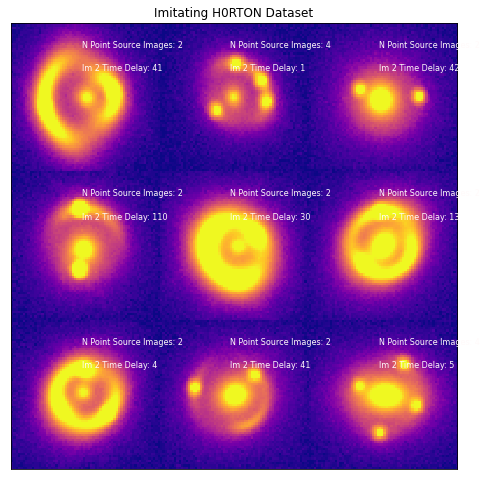

In [15]:
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)

# is this the best way to normalize?
nt=0
image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
norm=simple_norm(image/np.max(image), stretch='asinh', min_cut=1e-4)
#norm = None
npx = 64

#make a matrix and plot it once
matrix = np.ones((3*npx, 3*npx))
for i in range(0,3) :
    left_i = i*npx
    right_i = i*npx +npx
    for j in range(0,3) :
        left_j = j*npx
        right_j = j*npx + npx
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        matrix[left_i:right_i,left_j:right_j]= image
        nt+=1

plt.figure(figsize=(8,8))
plt.matshow(matrix,origin='lower',norm=norm,cmap='plasma',fignum=1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
m=0
for i in range(0,3):
    for j in range(0,3):
        num_images = metadata.at[m,'point_source_parameters_num_images']
        td = metadata.at[m,'point_source_parameters_time_delay_1']
        plt.text(j*npx+30,i*npx+npx-11,'N Point Source Images: %0d'%num_images, color="snow", fontsize=8)
        plt.text(j*npx+30,i*npx+npx-21,'Im 2 Time Delay: %0d'%td, color="snow", fontsize=8)
        m+=1
plt.title('H0RTON Configuration')
plt.show()